In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_05 import *

In [3]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,64
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
data.train_ds.x.shape

torch.Size([50000, 784])

In [6]:
learn = Learner(*get_model(data,lr=0.5), loss_func, data)

In [7]:
get_data??

In [8]:
get_dls??

In [9]:
optim.SGD??

In [10]:
def fit(epochs, learn):
    for epoch in range(epochs):
        learn.model.train()
        for xb,yb in learn.data.train_dl:
            loss = learn.loss_func(learn.model(xb),yb)
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()
            
        learn.model.eval()
        with torch.no_grad():
            tot_loss, tot_acc =0.,0.
            for xb,yb in learn.data.valid_dl:
                pred = learn.model(xb)
                tot_loss += learn.loss_func(pred,yb)
                tot_acc += accuracy(pred,yb)
            nv = len(learn.data.valid_dl)
            print(epoch,tot_loss/nv,tot_acc/nv)
    return tot_loss/nv,tot_acc/nv

In [11]:
loss,acc = fit(2, learn)

0 tensor(0.1528) tensor(0.9557)
1 tensor(0.1502) tensor(0.9556)


In [12]:
learn = Learner(*get_model(data), loss_func, data)

In [13]:
stats = AvgStatsCallback([accuracy])
run = Runner(cbs=stats)

In [14]:
run.fit(2, learn)

train: [0.31865990234375, tensor(0.9013)]
valid: [0.1993301025390625, tensor(0.9407)]
train: [0.1449315625, tensor(0.9566)]
valid: [0.19662698974609374, tensor(0.9396)]


In [15]:
get_model??

In [16]:
#export
class NewLearner():
    def __init__(self,model,opt,loss_func,data,lr,cbs=None, cb_funcs=None):
        self.model, self.opt, self.loss_func, self.data, self.lr = *get_model(data,lr), loss_func, data, lr
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs


    def one_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        if self('begin_batch'): return
        self.pred = self.model(self.xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred, self.yb)
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        if self('after_backward'): return
        self.opt.step()
        if self('after_step'): return
        self.opt.zero_grad()

    def one_epoch(self, dl):
        self.iters = len(dl)
        for xb,yb in dl:
            if self.stop: break
            self.one_batch(xb, yb)
            self('after_batch')
        self.stop=False

    def fit(self, epochs):
        self.epochs = epochs

        try:
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.one_epoch(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.one_epoch(self.data.valid_dl)
                if self('after_epoch'): break
            
        finally:
            self('after_fit')

    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, cb_name, None)
            if f and f(): return True
        return False

In [17]:
def get_nlearner(data,loss_func,lr=0.5,**kwargs):
    return NewLearner(*get_model(data),loss_func,data,lr,**kwargs)

In [18]:
nlearn = get_nlearner(data,loss_func,lr=0.5,cbs=stats)

In [19]:
nlearn.fit(2)

train: [0.3352639453125, tensor(0.8972)]
valid: [0.17151351318359376, tensor(0.9534)]
train: [0.154105927734375, tensor(0.9530)]
valid: [0.3806561767578125, tensor(0.8980)]


In [20]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

In [21]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [22]:
nlearn = get_nlearner(data,loss_func,lr=0.5,cb_funcs = cbfs)

In [23]:
nlearn.fit(3)

train: [0.36270515625, tensor(0.8921)]
valid: [0.753837744140625, tensor(0.8168)]
train: [0.1523390234375, tensor(0.9541)]
valid: [0.12195404052734375, tensor(0.9648)]
train: [0.092093212890625, tensor(0.9730)]
valid: [0.1004355224609375, tensor(0.9707)]


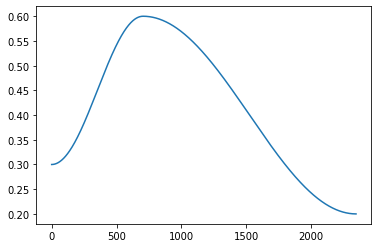

In [24]:
nlearn.recorder.plot_lr()

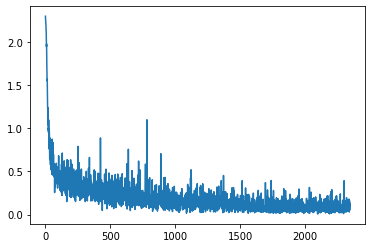

In [25]:
nlearn.recorder.plot_loss()

In [32]:
#export
class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [33]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
        
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])
        
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

In [51]:
#export
class NewLearner():
    def __init__(self,model,opt,loss_func,data,lr,cbs=None, cb_funcs=None):
        self.model, self.opt, self.loss_func, self.data, self.lr = *get_model(data,lr), loss_func, data, lr
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs


    def one_batch(self, xb, yb):
        try:
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

    def one_epoch(self, dl):
        self.iters = len(dl)
        try:
            for xb,yb in dl: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def fit(self, epochs):
        self.epochs,self.loss = epochs,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.one_epoch(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.one_epoch(self.data.valid_dl)
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')

    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) or res
        return res

In [52]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [61]:
nlearn = get_nlearner(data,loss_func,lr=0.5,cb_funcs = cbfs)

In [62]:
nlearn.fit(3)

train: [0.3483846875, tensor(0.8947)]
valid: [0.1915293701171875, tensor(0.9422)]
train: [0.152167255859375, tensor(0.9539)]
valid: [0.1069498779296875, tensor(0.9664)]
train: [0.0921901953125, tensor(0.9711)]
valid: [0.09752847900390625, tensor(0.9696)]


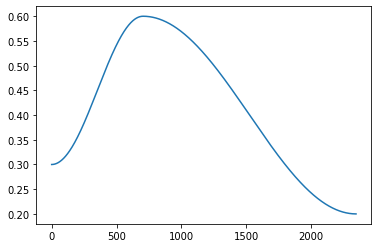

In [60]:
nlearn.recorder.plot_lr()

In [38]:
class TestCallback(Callback):
    _order=1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter>=10: raise CancelTrainException()

In [39]:
nlearn = get_nlearner(data,loss_func,lr=0.5,cb_funcs = TestCallback)

In [40]:
nlearn.fit(3)

0
1
2
3
4
5
6
7
8
9
10


In [41]:
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [46]:
nlearn = get_nlearner(data,loss_func,lr=0.5,cb_funcs = [LR_Find, Recorder])

In [47]:
nlearn.fit(2)

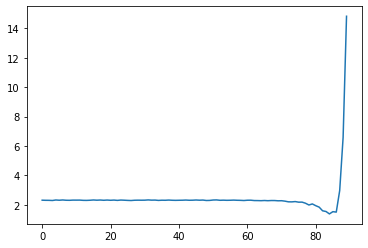

In [48]:
nlearn.recorder.plot_loss()

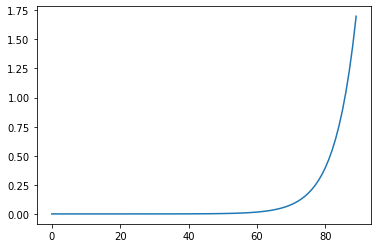

In [49]:
nlearn.recorder.plot_lr()

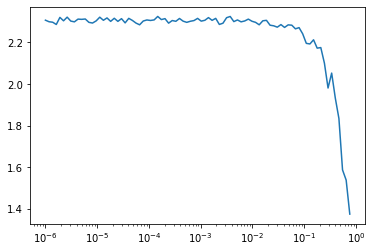

In [50]:
nlearn.recorder.plot(skip_last=5)